In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import OrderedDict

In [2]:
games = pd.read_csv("games_2011_to_2023.csv", parse_dates=["date"])
wins = games.loc[games.result == "W"]
schools = pd.read_csv(
    "general_data/schools.csv",
    skiprows=1,
    header=None,
    names=["school_id", "school_name"],
).set_index("school_id")

In [86]:
class ELO:
    def __init__(
        self,
        winners,
        losers,
        ids=None,
        timestamps=None,
        k=20,
        elo_init=1500,
        elo_diff=400,
        seasonal_mean_reversion=0,
    ):
        self.k = k
        self.elo_init = elo_init
        self.elo_diff = elo_diff

        winners = list(winners)
        losers = list(losers)

        ELO.__check_valid_games__(winners, losers, ids, timestamps)
        ELO.__check_valid_params__(k, elo_init, elo_diff, seasonal_mean_reversion)

        # Assemble temporary empty dataframe to store ELOs
        if ids is None:
            self.ids = range(len(winners))
        else:
            self.ids = ids
        self.winners = winners
        self.losers = losers
        self.competitors = sorted(list(set(winners) | set(losers)))
        self.timestamps = timestamps
        self.seasonal_mean_reversion = seasonal_mean_reversion
        if self.timestamps is not None:
            # sort arrays by timestamp
            self.ids, self.winners, self.losers, self.timestamps = zip(
                *sorted(
                    zip(self.ids, self.winners, self.losers, self.timestamps),
                    key=lambda x: x[3],
                )
            )

    # Compute the ELO of every competitor after each match (37s original)
    # 0.04476022720336914s (without dataframe conversion)
    # 0.15063881874084473 (with dataframe conversion)
    def fit_fastest(self):
        start = time.time()
        elo_dict = OrderedDict([(competitor, self.elo_init) for competitor in self.competitors])
        game_array = np.vstack([self.ids, self.winners, self.losers, self.timestamps]).T
        elo_array = [np.ones(len(self.competitors)) * self.elo_init]
        team_indices = {team: i for i, team in enumerate(self.competitors)}
        game_probs, winner_prev_elo, loser_prev_elo = [], [], []
        current_year = self.timestamps[0].year if self.timestamps is not None else None
        for i, game in enumerate(game_array):
            game_id, winner, loser, timestamp = game
            if self.timestamps is not None and timestamp.year != current_year:
                current_year = timestamp.year
                mean_elo = np.mean(elo_array[-1])
                elo_dict = {
                    team: mean_elo
                    + (1 - self.seasonal_mean_reversion) * (elo - mean_elo)
                    for team, elo in elo_dict.items()
                }
            winner_elo, loser_elo = elo_dict[winner], elo_dict[loser]
            winner_new_elo, loser_new_elo, expected_outcome_prob = (
                ELO.compute_pairwise_elo(
                    winner_elo, loser_elo, elo_diff=self.elo_diff, k=self.k
                )
            )
            game_probs.append(expected_outcome_prob)
            elo_dict[winner], elo_dict[loser] = winner_new_elo, loser_new_elo
            # new_game_row = elo_array[max(0, i - 1)].copy()
            # new_game_row[team_indices[winner]], new_game_row[team_indices[loser]] = (
            #     winner_new_elo,
            #     loser_new_elo,
            # )
            elo_array.append(list(elo_dict.values()))
        self.elo_df = pd.concat(
            [
                pd.DataFrame(
                    np.vstack(
                        [
                            self.ids,
                            self.timestamps,
                            self.winners,
                            self.losers,
                            game_probs,
                        ]
                    ).T,
                    columns=["id", "timestamp", "winner", "loser", "win_prob"],
                ).set_index("id"),
                pd.DataFrame(elo_array[1:], columns=self.competitors, index=self.ids),
            ],
            axis=1,
        )
        print("Computed elos in", time.time() - start, "seconds.")

    @staticmethod
    def compute_pairwise_elo(winner_elo, loser_elo, elo_diff, k):
        expected_outcome_prob = ELO.compute_expected_outcome_prob(
            winner_elo, loser_elo, elo_diff=elo_diff
        )
        return (
            winner_elo + k * (1 - expected_outcome_prob),
            loser_elo - k * (1 - expected_outcome_prob),
            expected_outcome_prob,
        )

    @staticmethod
    def compute_expected_outcome_prob(elo1, elo2, elo_diff=400):
        return 1 / (1 + 10 ** ((elo2 - elo1) / elo_diff))

    @staticmethod
    def __check_valid_params__(k, elo_init, elo_diff, seasonal_mean_reversion):
        assert isinstance(k, int) and k > 0
        assert isinstance(elo_init, int) and elo_init > 0
        assert isinstance(elo_diff, int) and elo_diff > 0
        assert (
            isinstance(seasonal_mean_reversion, float)
            and seasonal_mean_reversion <= 1
        )

    @staticmethod
    def __check_valid_games__(winners, losers, ids, timestamps):
        # assert proper data types
        assert pd.api.types.is_list_like(winners)
        assert pd.api.types.is_list_like(losers)
        assert ids is None or pd.api.types.is_list_like(ids)
        assert timestamps is None or pd.api.types.is_list_like(timestamps)

        # check that winners, losers, ids, and timestamps have the same length
        assert len(winners) == len(losers)
        assert ids is None or len(ids) == len(winners)
        assert timestamps is None or len(timestamps) == len(winners)

        # check that all ids are unique
        assert ids is None or len(set(ids)) == len(ids)

        # check that no teams play against themselves
        for i in range(len(winners)):
            assert winners[i] != losers[i]

        # check that the timestamps are valid
        if timestamps is not None:
            for timestamp in timestamps:
                try:
                    pd.to_datetime(timestamp)
                except ValueError:
                    raise ValueError("Invalid timestamp: {}".format(timestamp))

    def show_elos(self):
        return self.elo_df

In [92]:
1 / (1 + 10^1)

0.1

In [93]:
1 / (1 + 10**(1/2))

0.2402530733520421

In [49]:
b = OrderedDict([('a', 1), ('b', 2), ('c', 3)])

In [54]:
np.mean(list(b.values()))

2.0

In [4]:
elo_df = (
    wins[["date", "contest_id", "school_id", "opponent_school_id"]]
    .sort_values(by="date")
    .set_index("date")
)
elo_df.columns = ["id", "winner", "loser"]

In [59]:
e = ELO(elo_df["winner"], elo_df["loser"], ids=elo_df["id"], timestamps=elo_df.index, k=100, seasonal_mean_reversion=0.5)
e.fit_fastest()

Computed elos in 0.11908817291259766 seconds.


Computed elos in 0.10257101058959961 seconds.
0.7520420070011669


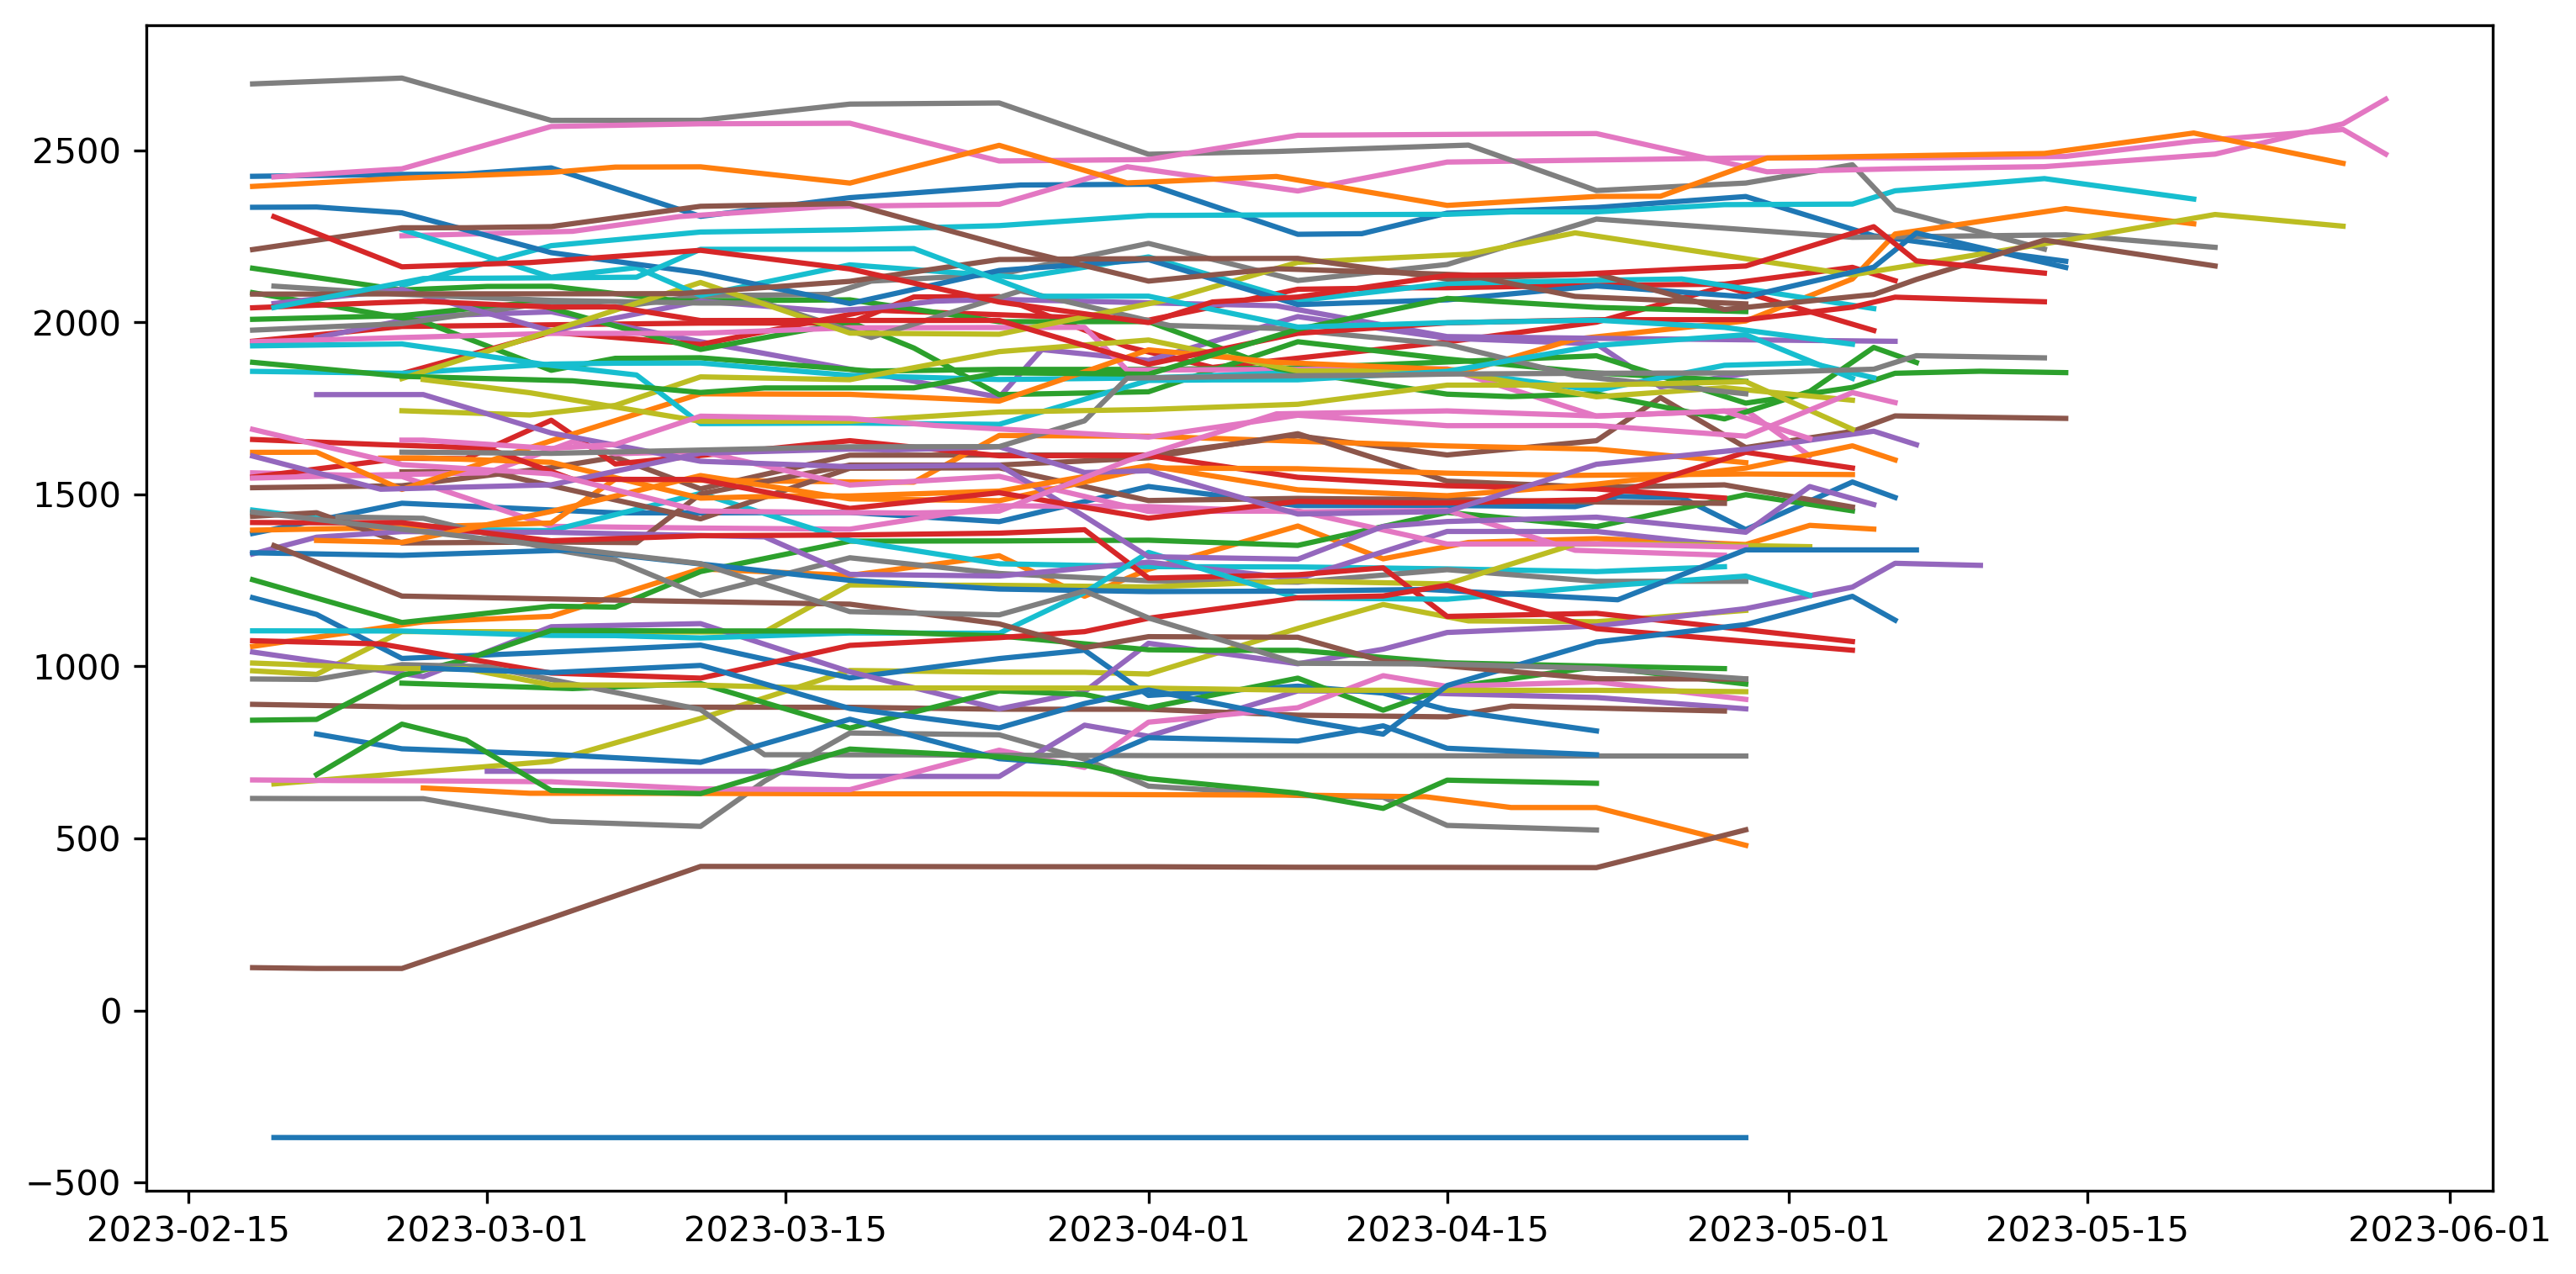

In [136]:
# for smr in np.arange(0, 1.1, 0.1):
sd = ELO(
    elo_df.winner,
    elo_df.loser,
    ids=elo_df.id,
    timestamps=elo_df.index,
    seasonal_mean_reversion=-0.1,
    k=150
)
sd.fit_fastest()
d = sd.show_elos()
plt.figure(dpi=300,figsize=(12, 6))
for school in sd.competitors:
    plt.plot(
        d.iloc[-500:].loc[(d.winner == school) | (d.loser == school)].timestamp,
        d.iloc[-500:].loc[(d.winner == school) | (d.loser == school)][school],
        label=schools.loc[school].school_name,
    )
print((d.loc[d.timestamp > '2020'].win_prob > 0.5).sum() / len(d.loc[d.timestamp > '2020']))

In [99]:
sd.show_elos()

,timestamp,winner,loser,win_prob,14,52,62,68,80,81,...,738,739,741,746,748,813,1320,11504,19651,30136
869377.0,2011-02-05,180,184,0.5,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
869378.0,2011-02-10,518,184,0.606288,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
869391.0,2011-02-12,52,184,0.683887,1500.000000,1547.416944,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
869379.0,2011-02-12,193,639,0.5,1500.000000,1547.416944,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
869386.0,2011-02-12,180,1320,0.606288,1500.000000,1547.416944,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1440.943174,1500.000000,1500.000000,1500.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433933.0,2023-05-21,513,322,0.757955,1490.947286,1399.050832,1452.162672,1976.418788,1851.369406,1720.839155,...,1689.133102,1936.365518,743.069281,2550.402217,660.143385,2143.130785,511.828617,963.118777,1766.900417,963.69021
2433934.0,2023-05-21,539,725,0.498958,1490.947286,1399.050832,1452.162672,1976.418788,1851.369406,1720.839155,...,1689.133102,1936.365518,743.069281,2550.402217,660.143385,2143.130785,511.828617,963.118777,1766.900417,963.69021
2433917.0,2023-05-27,513,746,0.41255,1490.947286,1399.050832,1452.162672,1976.418788,1851.369406,1720.839155,...,1689.133102,1936.365518,743.069281,2462.284764,660.143385,2143.130785,511.828617,963.118777,1766.900417,963.69021
2433918.0,2023-05-27,193,539,0.773164,1490.947286,1399.050832,1452.162672,1976.418788,1851.369406,1720.839155,...,1689.133102,1936.365518,743.069281,2462.284764,660.143385,2143.130785,511.828617,963.118777,1766.900417,963.69021


In [87]:
accs = {}
for k in range(50, 325, 25):
    for elo_diff in range(400, 401, 200):
        for smr in np.arange(-0.3, 0.3, 0.1):
            e = ELO(
                elo_df.winner,
                elo_df.loser,
                ids=elo_df.id,
                timestamps=elo_df.index,
                k=k,
                elo_diff=elo_diff,
                seasonal_mean_reversion=smr,
            )
            e.fit_fastest()
            df = e.show_elos()
            nf = df.rename(
                columns={
                    school: schools.loc[school].school_name for school in df.columns[4:]
                }
            )
            accs[(k, elo_diff, smr)] = (
                nf.loc[nf.timestamp > "2020"].win_prob > 0.5
            ).sum() / len(nf.loc[nf.timestamp > "2020"])

Computed elos in 0.09929323196411133 seconds.
Computed elos in 0.0899195671081543 seconds.
Computed elos in 0.08826804161071777 seconds.
Computed elos in 0.0967109203338623 seconds.
Computed elos in 0.09313440322875977 seconds.
Computed elos in 0.0916907787322998 seconds.
Computed elos in 0.09035897254943848 seconds.
Computed elos in 0.08601593971252441 seconds.
Computed elos in 0.08474183082580566 seconds.
Computed elos in 0.08719944953918457 seconds.
Computed elos in 0.09155869483947754 seconds.
Computed elos in 0.08722662925720215 seconds.
Computed elos in 0.09258341789245605 seconds.
Computed elos in 0.08788490295410156 seconds.
Computed elos in 0.10238504409790039 seconds.
Computed elos in 0.0918877124786377 seconds.
Computed elos in 0.08802485466003418 seconds.
Computed elos in 0.08439350128173828 seconds.
Computed elos in 0.08584403991699219 seconds.
Computed elos in 0.08822894096374512 seconds.
Computed elos in 0.1107032299041748 seconds.
Computed elos in 0.09048652648925781 se

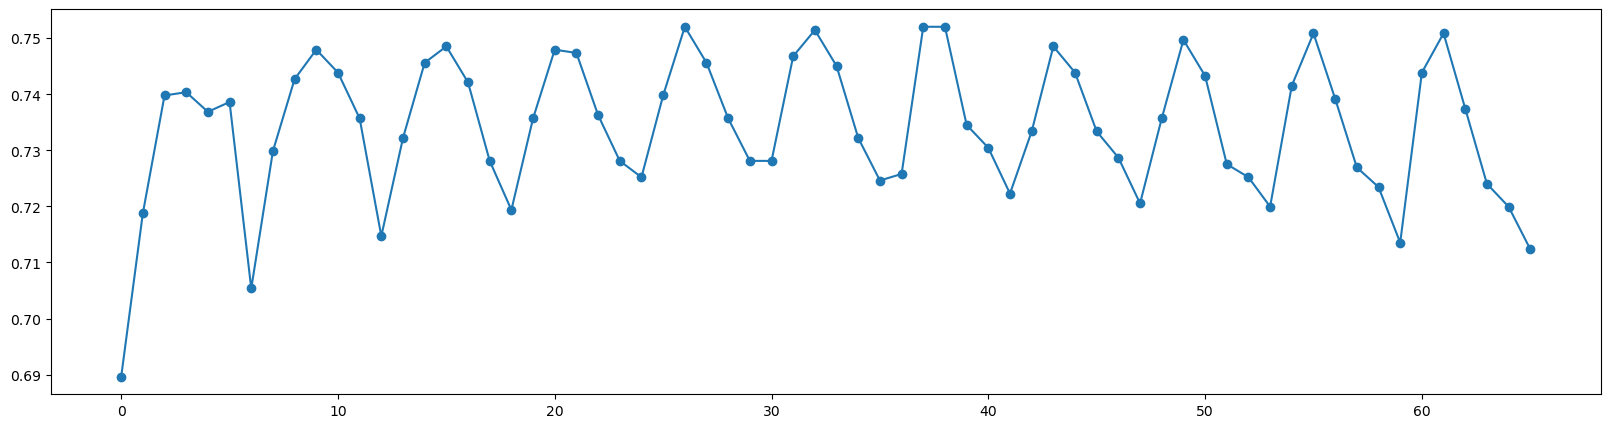

In [88]:
ac = list(accs.values())
plt.figure(figsize=(20, 5))
plt.plot(ac, marker="o")

In [89]:
max_key = max(accs, key=lambda k: accs[k])

In [90]:
max_key

(150, 400, -0.09999999999999998)

In [91]:
max(ac)

0.7520420070011669

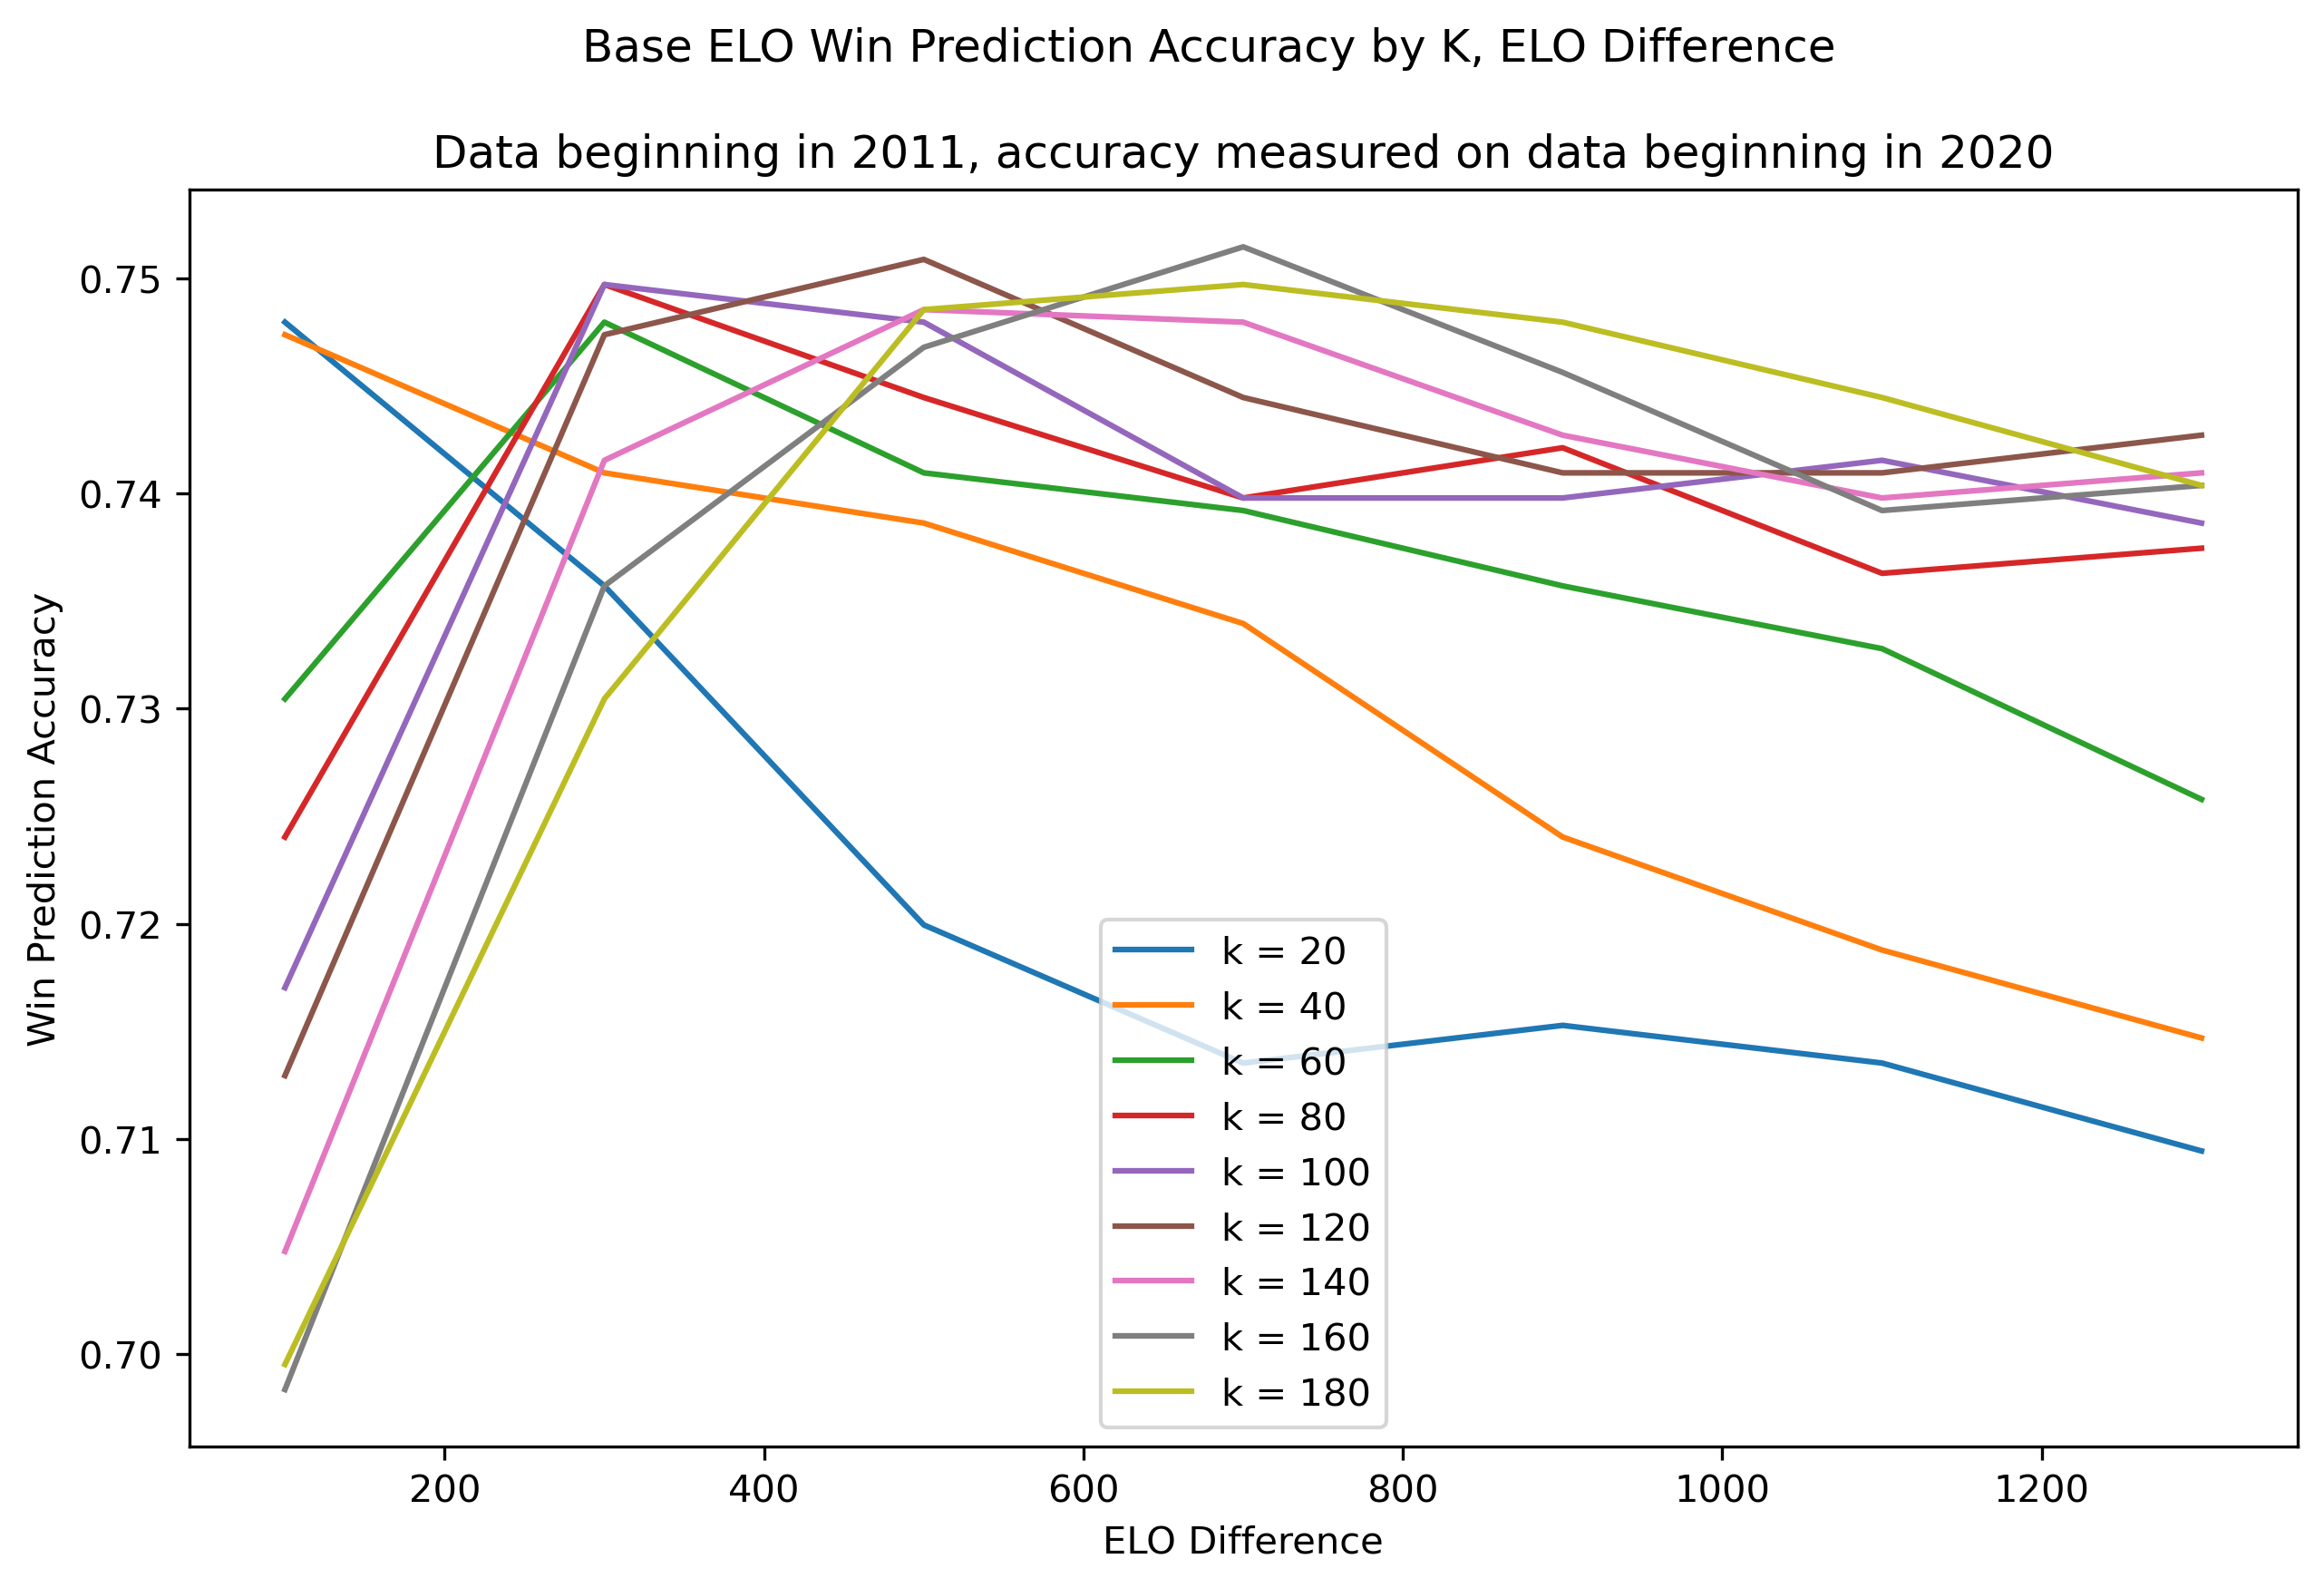

In [21]:
import matplotlib.pyplot as plt



# Extract x, y, and z values from the accs dictionary
x = []
y = []
z = []
for key, value in accs.items():
    x.append(key[1])  # Use key[1] as x-axis
    y.append(value)  # Use value as y-axis
    z.append(key[0])  # Use key[0] as line identifier

plt.figure(dpi=300, figsize=(10, 6))
for line_id in sorted(list(set(z))):
    line_x = [x[i] for i in range(len(z)) if z[i] == line_id]
    line_y = [y[i] for i in range(len(z)) if z[i] == line_id]
    plt.plot(line_x, line_y, label=f"k = {line_id}")

# Set labels and title
plt.xlabel("ELO Difference")
plt.ylabel("Win Prediction Accuracy")
plt.suptitle("Base ELO Win Prediction Accuracy by K, ELO Difference")
plt.title("Data beginning in 2011, accuracy measured on data beginning in 2020")

# Add legend
plt.legend()

In [7]:
min(accs.values())

0.7281213535589265

In [8]:
school_dict = schools.to_dict()["school_name"]
df["winner_name"] = df.apply(lambda x: school_dict[x.winner], axis=1)
df["loser_name"] = df.apply(lambda x: school_dict[x.loser], axis=1)
df_prev = pd.concat([df.iloc[:, :3], df.iloc[:, 3:].shift()], axis=1)
df["winner_prev_elo"] = df_prev.apply(lambda x: x[x.winner], axis=1)
df["loser_prev_elo"] = df_prev.apply(lambda x: x[x.loser], axis=1)
# df['winner_win_prob'] = df.apply(lambda x: ELO.compute_expected_outcome_prob(x.winner_prev_elo, x.loser_prev_elo), axis=1)
# plt.figure(dpi=300, figsize=(5, 10))
# for team in nf.columns[3:]:
#     plt.plot(nf.timestamp, nf[team], label=team, alpha=0.5)

In [9]:
df

,timestamp,winner,loser,win_prob,14,52,62,68,80,81,...,748,813,1320,11504,19651,30136,winner_name,loser_name,winner_prev_elo,loser_prev_elo
869377.0,2011-02-05,180,184,0.5,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,Delaware,Detroit Mercy,NaN,NaN
869378.0,2011-02-10,518,184,0.626699,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,Ohio St.,Detroit Mercy,1500.000000,1410.000000
869391.0,2011-02-12,52,184,0.711952,1500.000000,1551.848677,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,Bellarmine,Detroit Mercy,1500.000000,1342.805835
869379.0,2011-02-12,193,639,0.5,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,Duke,Siena,1500.000000,1500.000000
869386.0,2011-02-12,180,1320,0.626699,1500.000000,1551.848677,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1432.805835,1500.000000,1500.000000,1500.000000,Delaware,Presbyterian,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433933.0,2023-05-21,513,322,0.730678,1478.920435,1467.549995,1459.912875,1845.395151,1737.633133,1733.817847,...,804.455351,2004.520962,1151.504418,1001.025943,1592.820143,958.695555,Notre Dame,Johns Hopkins,2293.491509,2120.109849
2433934.0,2023-05-21,539,725,0.534061,1466.457883,1483.124272,1492.367339,1792.119511,1663.752760,1714.386224,...,775.354776,2035.797688,1195.911920,999.962902,1704.251901,983.410089,Penn St.,Army West Point,2157.355017,2133.650532
2433917.0,2023-05-27,513,746,0.365984,1478.920435,1467.549995,1459.912875,1845.395151,1737.633133,1733.817847,...,804.455351,2004.520962,1151.504418,1001.025943,1592.820143,958.695555,Notre Dame,Virginia,2293.491509,2437.424648
2433918.0,2023-05-27,193,539,0.732364,1466.457883,1483.124272,1492.367339,1792.119511,1663.752760,1714.386224,...,775.354776,2035.797688,1195.911920,999.962902,1704.251901,983.410089,Duke,Penn St.,2416.096771,2157.355017
